# Mini Project 1 - SVM & LR Classification -- 2013/2014 CitiBike-NYC Data
**Michael Smith, Alex Frye, Chris Boomhower ----- 2/08/2017**

<img src="https://github.com/msmith-ds/DataMining/blob/master/Project2/Images/Citi-Bike.jpg?raw=true" width="400">

<center>Image courtesy of http://newyorkeronthetown.com/, 2017</center>

### Introduction
*** Describe the purpose of the model you are about to build ***

The data set again selected by our group for the mini-lab consists of [Citi Bike trip history](https://www.citibikenyc.com/system-data) data collected and released by NYC Bike Share, LLC and Jersey Bike Share, LLC under Citi Bike's [NYCBS Data Use Policy](https://www.citibikenyc.com/data-sharing-policy). Citi Bike is America's largest bike share program, with 10,000 bikes and 600 stations across Manhattan, Brooklyn, Queens, and Jersey City... 55 neighborhoods in all. As such, our data set's trip history includes all rental transactions conducted within the NYC Citi Bike system from July 1st, 2013 to February 28th, 2014. These transactions amount to 5,562,293 trips within this time frame. The original data set includes 15 attributes. In addition to these 15, our team was able to derive 15 more attributes for use in our classification efforts, some attributes of which are NYC weather data which come from [Carbon Dioxide Information Analysis Center (CDIAC)](http://cdiac.ornl.gov/cgi-bin/broker?_PROGRAM=prog.climsite_daily.sas&_SERVICE=default&id=305801&_DEBUG=0). These data are merged with the Citi Bike data to provide environmental insights into rider behaviour.

The trip data was collected via Citi Bike's check-in/check-out system among 330 of its stations in the NYC system as part of its transaction history log. While the non-publicized data likely includes further particulars such as rider payment details, the publicized data is anonymized to protect rider identity while simultaneously offering bike share transportation insights to urban developers, engineers, academics, statisticians, and other interested parties. The CDIAC data, however, was collected by the Department of Energy's Oak Ridge National Laboratory for research into global climate change. While basic weather conditions are recorded by CDIAC, as included in our fully merged data set, the organization also measures atmospheric carbon dioxide and other radiatively active gas levels to conduct their research efforts.

Our team has taken particular interest in this data set as some of our team members enjoy both recreational and commute cycling. By combining basic weather data with Citi Bike's trip data, **our intent in this mini-lab is to predict whether riders are more likely to be (or become) Citi Bike subscribers based on ride environmental conditions, the day of the week for his/her trip, trip start and end locations, the general time of day (i.e. morning, midday, afternoon, evening, night) of his/her trip, his/her age and gender, etc.** Due to the exhaustive number of observations in the original data set (5,562,293), a sample of 500,000 is selected to achieve this goal (as described further in the sections below). By leveraging 80% of the samples as training data and 20% as test data via randomized selection, we expect to be able to derive a dependable and accurate user type prediction model for which accuracy and performance will be discussed in detail.

### Load the Data

##### Compiling Multiple Data Sources
To begin our analysis, we need to load the data from our source .csv files. Steps taken to pull data from the various source files are as follows:
- For each file from CitiBike, we process each line appending manually computed columns [LinearDistance, DayOfWeek, TimeOfDay, & HolidayFlag]. 
- Similarly, we load our weather data .csv file.
- With both source file variables gathered, we append the weather data to our CitiBike data by matching on the date.
- To avoid a 2 hour run-time in our analysis every execution, we load the final version of the data into .CSV files. Each file consists of 250000 records to reduce file size for GitHub loads.
- All above logic is skipped if the file "Compiled Data/dataset1.csv" already exists.

Below you will see this process, as well as import/options for needed python modules throughout this analysis.

In [1]:
import os
from geopy.distance import vincenty
import holidays
from datetime import datetime
from dateutil.parser import parse
import glob
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

C:\Users\Owner\Anaconda2\envs\Py3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
############################################################
# Load & Merge Data from Source Files
# Parse into Compiled Files
############################################################

starttime = datetime.now()
print('Starting Source Data Load & Merge Process. \n'
      'Start Time: ' + str(starttime))

if os.path.isfile("Compiled Data/dataset1.csv"):
    print("Found the File!")
else:
    citiBikeDataDirectory = "Citi Bike Data"
    citiBikeDataFileNames = [
        "2013-07 - Citi Bike trip data - 1.csv",
        "2013-07 - Citi Bike trip data - 2.csv",
        "2013-08 - Citi Bike trip data - 1.csv",
        "2013-08 - Citi Bike trip data - 2.csv",
        "2013-09 - Citi Bike trip data - 1.csv",
        "2013-09 - Citi Bike trip data - 2.csv",
        "2013-10 - Citi Bike trip data - 1.csv",
        "2013-10 - Citi Bike trip data - 2.csv",
        "2013-11 - Citi Bike trip data - 1.csv",
        "2013-11 - Citi Bike trip data - 2.csv",
        "2013-12 - Citi Bike trip data.csv",
        "2014-01 - Citi Bike trip data.csv",
        "2014-02 - Citi Bike trip data.csv"
    ]

    weatherDataFile = "Weather Data/NY305801_9255_edited.txt"

    citiBikeDataRaw = []

    for file in citiBikeDataFileNames:
        print(file)
        filepath = citiBikeDataDirectory + "/" + file
        with open(filepath) as f:
            lines = f.read().splitlines()
            lines.pop(0)  # get rid of the first line that contains the column names
            for line in lines:
                line = line.replace('"', '')
                line = line.split(",")
                sLatLong = (line[5], line[6])
                eLatLong = (line[9], line[10])

                distance = vincenty(sLatLong, eLatLong).miles
                line.extend([distance])

                ## Monday       = 0
                ## Tuesday      = 1
                ## Wednesday    = 2
                ## Thursday     = 3
                ## Friday       = 4
                ## Saturday     = 5
                ## Sunday       = 6
                if parse(line[1]).weekday() == 0:
                    DayOfWeek = "Monday"
                elif parse(line[1]).weekday() == 1:
                    DayOfWeek = "Tuesday"
                elif parse(line[1]).weekday() == 2:
                    DayOfWeek = "Wednesday"
                elif parse(line[1]).weekday() == 3:
                    DayOfWeek = "Thursday"
                elif parse(line[1]).weekday() == 4:
                    DayOfWeek = "Friday"
                elif parse(line[1]).weekday() == 5:
                    DayOfWeek = "Saturday"
                else:
                    DayOfWeek = "Sunday"
                line.extend([DayOfWeek])

                ##Morning       5AM-10AM
                ##Midday        10AM-2PM
                ##Afternoon     2PM-5PM
                ##Evening       5PM-10PM
                ##Night         10PM-5AM

                if parse(line[1]).hour >= 5 and parse(line[1]).hour < 10:
                    TimeOfDay = 'Morning'
                elif parse(line[1]).hour >= 10 and parse(line[1]).hour < 14:
                    TimeOfDay = 'Midday'
                elif parse(line[1]).hour >= 14 and parse(line[1]).hour < 17:
                    TimeOfDay = 'Afternoon'
                elif parse(line[1]).hour >= 17 and parse(line[1]).hour < 22:
                    TimeOfDay = 'Evening'
                else:
                    TimeOfDay = 'Night'
                line.extend([TimeOfDay])

                ## 1 = Yes
                ## 0 = No
                if parse(line[1]) in holidays.UnitedStates():
                    holidayFlag = "1"
                else:
                    holidayFlag = "0"
                line.extend([holidayFlag])

                citiBikeDataRaw.append(line)
            del lines

    with open(weatherDataFile) as f:
        weatherDataRaw = f.read().splitlines()
        weatherDataRaw.pop(0)  # again, get rid of the column names
        for c in range(len(weatherDataRaw)):
            weatherDataRaw[c] = weatherDataRaw[c].split(",")
            # Adjust days and months to have a leading zero so we can capture all the data
            if len(weatherDataRaw[c][2]) < 2:
                weatherDataRaw[c][2] = "0" + weatherDataRaw[c][2]
            if len(weatherDataRaw[c][0]) < 2:
                weatherDataRaw[c][0] = "0" + weatherDataRaw[c][0]

    citiBikeData = []

    while (citiBikeDataRaw):
        instance = citiBikeDataRaw.pop()
        date = instance[1].split(" ")[0].split("-")  # uses the start date of the loan
        for record in weatherDataRaw:
            if (str(date[0]) == str(record[4]) and str(date[1]) == str(record[2]) and str(date[2]) == str(record[0])):
                instance.extend([record[5], record[6], record[7], record[8], record[9]])
                citiBikeData.append(instance)

    del citiBikeDataRaw
    del weatherDataRaw

    # Final Columns:
    #  0 tripduration
    #  1 starttime
    #  2 stoptime
    #  3 start station id
    #  4 start station name
    #  5 start station latitude
    #  6 start station longitude
    #  7 end station id
    #  8 end station name
    #  9 end station latitude
    # 10 end station longitude
    # 11 bikeid
    # 12 usertype
    # 13 birth year
    # 14 gender
    # 15 start/end station distance
    # 16 DayOfWeek
    # 17 TimeOfDay
    # 18 HolidayFlag
    # 19 PRCP
    # 20 SNOW
    # 21 TAVE
    # 22 TMAX
    # 23 TMIN

    maxLineCount = 250000
    lineCounter = 1
    fileCounter = 1
    outputDirectoryFilename = "Compiled Data/dataset"
    f = open(outputDirectoryFilename + str(fileCounter) + ".csv", "w")
    for line in citiBikeData:
        if lineCounter == 250000:
            print(f)
            f.close()
            lineCounter = 1
            fileCounter = fileCounter + 1
            f = open(outputDirectoryFilename + str(fileCounter) + ".csv", "w")
        f.write(",".join(map(str, line)) + "\n")
        lineCounter = lineCounter + 1

    del citiBikeData

endtime = datetime.now()
print('Ending Source Data Load & Merge Process. \n'
      'End Time: ' + str(starttime) + '\n'
                                      'Total RunTime: ' + str(endtime - starttime))

##### Loading the Compiled Data from CSV

Now that we have compiled data files from both CitiBike and the weather data, we want to load that data into a Pandas dataframe for analysis. We iterate and load each file produced above, then assign each column with their appropriate data types. Additionally, we compute the Age Column after producing a default value for missing "Birth Year" values. This is discussed further in the Data Quality section.

In [2]:
%%time
############################################################
# Load the Compiled Data from CSV
############################################################

# Create CSV Reader Function and assign column headers
def reader(f, columns):
    d = pd.read_csv(f)
    d.columns = columns
    return d


# Identify All CSV FileNames needing to be loaded
path = r'Compiled Data'
all_files = glob.glob(os.path.join(path, "*.csv"))

# Define File Columns
columns = ["tripduration", "starttime", "stoptime", "start_station_id", "start_station_name",
           "start_station_latitude",
           "start_station_longitude", "end_station_id", "end_station_name", "end_station_latitude",
           "end_station_longitude", "bikeid", "usertype", "birth year", "gender", "LinearDistance", "DayOfWeek",
           "TimeOfDay", "HolidayFlag", "PRCP", "SNOW", "TAVE", "TMAX", "TMIN"]

# Load Data
CitiBikeDataCompiled = pd.concat([reader(f, columns) for f in all_files])

# Replace '\N' Birth Years with Zero Values
CitiBikeDataCompiled["birth year"] = CitiBikeDataCompiled["birth year"].replace(r'\N', '0')

# Convert Columns to Numerical Values
CitiBikeDataCompiled[['tripduration', 'birth year', 'LinearDistance', 'PRCP', 'SNOW', 'TAVE', 'TMAX', 'TMIN']] \
    = CitiBikeDataCompiled[['tripduration', 'birth year', 'LinearDistance', 'PRCP', 'SNOW', 'TAVE', 'TMAX',
                            'TMIN']].apply(pd.to_numeric)

# Convert Columns to Date Values
CitiBikeDataCompiled[['starttime', 'stoptime']] \
    = CitiBikeDataCompiled[['starttime', 'stoptime']].apply(pd.to_datetime)

# Compute Age: 0 Birth Year = 0 Age ELSE Compute Start Time Year Minus Birth Year
CitiBikeDataCompiled["Age"] = np.where(CitiBikeDataCompiled["birth year"] == 0, 0,
                                       CitiBikeDataCompiled["starttime"].dt.year - CitiBikeDataCompiled[
                                           "birth year"])

# Convert Columns to Str Values
CitiBikeDataCompiled[['start_station_id', 'end_station_id', 'bikeid', 'HolidayFlag', 'gender']] \
    = CitiBikeDataCompiled[['start_station_id', 'end_station_id', 'bikeid', 'HolidayFlag', 'gender']].astype(str)

Wall time: 2min 1s


In [3]:
%%time
print(len(CitiBikeDataCompiled))
display(CitiBikeDataCompiled.head())

5562293


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth year,gender,LinearDistance,DayOfWeek,TimeOfDay,HolidayFlag,PRCP,SNOW,TAVE,TMAX,TMIN,Age
0,308,2014-02-28 23:59:10,2014-03-01 00:04:18,353,S Portland Ave & Hanson Pl,40.685396,-73.974315,365,Fulton St & Grand Ave,40.682232,-73.961458,14761,Subscriber,1982,1,0.709731,Friday,Night,0,0.0,0.0,17,24,9,32
1,304,2014-02-28 23:58:17,2014-03-01 00:03:21,497,E 17 St & Broadway,40.737050,-73.990093,334,W 20 St & 7 Ave,40.742388,-73.997262,17112,Subscriber,1968,1,0.526555,Friday,Night,0,0.0,0.0,17,24,9,46
2,1355,2014-02-28 23:57:55,2014-03-01 00:20:30,470,W 20 St & 8 Ave,40.743453,-74.000040,302,Avenue D & E 3 St,40.720828,-73.977932,15608,Subscriber,1985,2,1.945255,Friday,Night,0,0.0,0.0,17,24,9,29
3,848,2014-02-28 23:57:13,2014-03-01 00:11:21,498,Broadway & W 32 St,40.748549,-73.988084,432,E 7 St & Avenue A,40.726218,-73.983799,17413,Subscriber,1976,1,1.557209,Friday,Night,0,0.0,0.0,17,24,9,38
4,175,2014-02-28 23:57:12,2014-03-01 00:00:07,383,Greenwich Ave & Charles St,40.735238,-74.000271,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,15220,Subscriber,1956,1,0.288829,Friday,Night,0,0.0,0.0,17,24,9,58


Wall time: 275 ms


### Data Quality

##### Measurable Data Quality Factors
When analyzing our final dataset for accurate measures, there are a few key factors we can easily verify/research:
- Computational Accuracy: Ensure data attributes added by computation are correct
    + TimeOfDay
    + DayOfWeek        
    + HolidayFlag
    
- Missing Data from Source
- Duplicate Data from Source
- Outlier Detection
- Sampling to 500,000 Records for further analysis

##### Immesurable Data Quality Factors
Although we are able to research these many factors, one computation still may still be lacking information in this dataset. Our LinearDistance attribute computes the distance from  one lat/long coordinate to another. This attribute does not however tell us the 'true' distance a biker traveled before returning the bike. Some bikers may be biking for exercise around the city with various turns and loops, whereas others travel the quickest path to their destination. Because our dataset limits us to start and end locations, we do not have enough information to accurately compute distance traveled. Because of this, we have named the attribute "LinearDistance" rather than "DistanceTraveled".

Below we will walk through the process of researching the 'Measureable' data quality factors mentioned above:

###### Computational Accuracy:TimeOfDay
To help mitigate challenges with time series data, we have chosen to break TimeOfDay into 5 categories.
These Categories are broken down below:
- Morning       5  AM  -  10 AM
- Midday        10 AM  -  2  PM
- Afternoon     2  PM  -  5  PM
- Evening       5  PM  -  10 PM
- Night         10 PM  -  5  AM

To ensure that these breakdowns are accurately computed, we pulled the distinct list of TimeOfDay assignments by starttime hour. Looking at the results below, we can verify that this categorization is correctly being assigned.

In [4]:
%%time
    # Compute StartHour from StartTime
CitiBikeDataCompiled["StartHour"] = CitiBikeDataCompiled["starttime"].dt.hour

    # Compute Distinct Combinations of StartHour and TimeOfDay
DistinctTimeOfDayByHour = CitiBikeDataCompiled[["StartHour", "TimeOfDay"]].drop_duplicates().sort_values("StartHour")

    # Print
display(DistinctTimeOfDayByHour)

    #Clean up Variables
del CitiBikeDataCompiled["StartHour"]

,StartHour,TimeOfDay
9517,0,Night
9482,1,Night
9470,2,Night
9457,3,Night
9437,4,Night
9362,5,Morning
9147,6,Morning
8642,7,Morning
7644,8,Morning
6866,9,Morning


Wall time: 5.1 s


###### Computational Accuracy:DayOfWeek
In order to verify our computed DayOfWeek column, we have chosen one full week from 12/22/2013 - 12/28/2013 to validate. Below is a calendar image of this week to baseline our expected results:

<img src="https://github.com/msmith-ds/DataMining/blob/master/Project2/Images/Dec_2013_Calendar.png?raw=true" width="300">

To verify these 7 days, we pulled the distinct list of DayOfWeek assignments by StartDate (No Time). If we can verify one full week, we may justify that the computation is correct across the entire dataset. Looking at the results below, we can verify that this categorization is correctly being assigned.

In [5]:
%%time
    # Create DataFrame for StartTime, DayOfWeek within Date Threshold
CitiBikeDayOfWeekTest = CitiBikeDataCompiled[(CitiBikeDataCompiled['starttime'].dt.year == 2013)
                                             & (CitiBikeDataCompiled['starttime'].dt.month == 12)
                                             & (CitiBikeDataCompiled['starttime'].dt.day >= 22)
                                             & (CitiBikeDataCompiled['starttime'].dt.day <= 28)][
    ["starttime", "DayOfWeek"]]

    # Create FloorDate Variable as StartTime without the timestamp
CitiBikeDayOfWeekTest["StartFloorDate"] = CitiBikeDayOfWeekTest["starttime"].dt.strftime('%m/%d/%Y')

    # Compute Distinct combinations
DistinctDayOfWeek = CitiBikeDayOfWeekTest[["StartFloorDate", "DayOfWeek"]].drop_duplicates().sort_values(
    "StartFloorDate")

    #Print
display(DistinctDayOfWeek)

    # Clean up Variables
del CitiBikeDayOfWeekTest
del DistinctDayOfWeek

,StartFloorDate,DayOfWeek
107323,12/22/2013,Sunday
100367,12/23/2013,Monday
89342,12/24/2013,Tuesday
86082,12/25/2013,Wednesday
76319,12/26/2013,Thursday
64599,12/27/2013,Friday
52577,12/28/2013,Saturday


Wall time: 2.84 s


###### Computational Accuracy:HolidayFlag
Using the same week as was used to verify DayOfWeek, w can test whether HolidayFlag is set correctly for the Christmas Holiday. We pulled the distinct list of HolidayFlag assignments by StartDate (No Time). If we can verify one holiday, we may justify that the computation is correct across the entire dataset. Looking at the results below, we expect to see HolidayFlag = 1 only for 12/25/2013.

In [6]:
%%time
    # Create DataFrame for StartTime, HolidayFlag within Date Threshold
CitiBikeHolidayFlagTest = CitiBikeDataCompiled[(CitiBikeDataCompiled['starttime'].dt.year == 2013)
                                             & (CitiBikeDataCompiled['starttime'].dt.month == 12)
                                             & (CitiBikeDataCompiled['starttime'].dt.day >= 22)
                                             & (CitiBikeDataCompiled['starttime'].dt.day <= 28)][
    ["starttime", "HolidayFlag"]]

    # Create FloorDate Variable as StartTime without the timestamp
CitiBikeHolidayFlagTest["StartFloorDate"] = CitiBikeHolidayFlagTest["starttime"].dt.strftime('%m/%d/%Y')

    # Compute Distinct combinations
DistinctHolidayFlag = CitiBikeHolidayFlagTest[["StartFloorDate", "HolidayFlag"]].drop_duplicates().sort_values(
    "StartFloorDate")
    
    #Print
display(DistinctHolidayFlag)
    
    # Clean up Variables
del CitiBikeHolidayFlagTest
del DistinctHolidayFlag


,StartFloorDate,HolidayFlag
107323,12/22/2013,0
100367,12/23/2013,0
89342,12/24/2013,0
86082,12/25/2013,1
76319,12/26/2013,0
64599,12/27/2013,0
52577,12/28/2013,0


Wall time: 2.85 s


###### Missing Data from Source
Accounting for missing data is a crucial part of our analysis. At first glance, it is very apparent that we have a large amount of missing data in the Gender and Birth Year attributes from our source CitiBike Data. We have already had to handle for missing Birth Year attributes while computing "Age" in our Data Load from CSV section of this paper. This was done to create a DEFAULT value of (0), such that future computations do not result in NA values as well. Gender has also already accounted for missing values with a default value of (0) by the source data. Although we have handled these missing values with a default, we want to ensure that we 'need' these records for further analysis - or if we may remove them from the dataset. Below you will see a table showing the frequency of missing values(or forced default values) by usertype. We noticed that of the 4881384 Subscribing Members in our dataset, only 295 of them were missing Gender information, whereas out of the  680909 Customer Users (Non-Subscribing), there was only one observation where we had complete information for both Gender and Birth Year. This quickly told us that removing records with missing values is NOT an option, since we would lose data for our entire Customer Usertype. These attributes, as well as Age (Computed from birth year) will serve as difficult for use in a classification model attempting to predict usertype. 

We have also looked at all other attributes, and verified that there are no additional missing values in our dataset. A missing value matrix was produced to identify if there were any gaps in our data across all attributes. Due to the conclusive results in our data, no missing values present, we removed this lackluster visualization from the report.

In [7]:
%%time
NADatatestData = CitiBikeDataCompiled[["usertype","gender", "birth year"]]

NADatatestData["GenderISNA"] = np.where(CitiBikeDataCompiled["gender"] == '0', 1, 0)
NADatatestData["BirthYearISNA"] = np.where(CitiBikeDataCompiled["birth year"] == 0, 1,0)

NAAggs = pd.DataFrame({'count' : NADatatestData.groupby(["usertype","GenderISNA", "BirthYearISNA"]).size()}).reset_index()

display(NAAggs)

del NAAggs

,usertype,GenderISNA,BirthYearISNA,count
0,Customer,0,0,1
1,Customer,0,1,42
2,Customer,1,0,73
3,Customer,1,1,680793
4,Subscriber,0,0,4881089
5,Subscriber,1,0,295


Wall time: 2.99 s


###### Duplicate Data from Source
To ensure that there are no duplicate records in our datasets, we ensured that the number of records before and after removing potential duplicates were equal to eachother. This test passed, thus we did not need any alterations to the dataset based on duplicate records.

In [8]:
%%time
len(CitiBikeDataCompiled) == len(CitiBikeDataCompiled.drop_duplicates())

Wall time: 45.5 s


True

###### Outlier Detection

**Trip Duration**
In analyzing a Box Plot on trip duration values, we find extreme outliers present. With durations reaching up to 72 days in the most extreme instance, our team decided to rule out any observation with a duration greater than a 24 period. The likelihood of an individual sleeping overnight after their trip with the bike still checked out is much higher after the 24 hour period. This fact easily skews the results of this value, potentially hurting any analysis done. We move forward with removing a total of 457 observations based on trip duration greater than 24 hours (86,400 seconds).

457
Wall time: 18.9 s


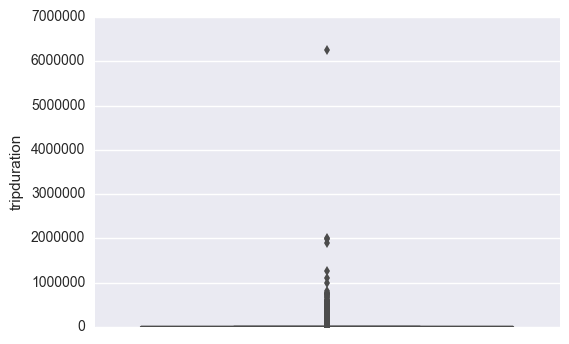

In [9]:
%%time
%matplotlib inline

#CitiBikeDataCompiledBackup = CitiBikeDataCompiled
#CitiBikeDataCompiled = CitiBikeDataCompiledBackup

    # BoxPlot tripDuration - Heavy Outliers!
sns.boxplot(y = "tripduration", data = CitiBikeDataCompiled)
sns.despine()
    
    # How Many Greater than 24 hours?
print(len(CitiBikeDataCompiled[CitiBikeDataCompiled["tripduration"]>86400]))

    # Remove > 24 Hours
CitiBikeDataCompiled = CitiBikeDataCompiled[CitiBikeDataCompiled["tripduration"]<86400]

Once outliers are removed, we run the boxplot again, still seeing skewness in results. To try to mitigate this left-skew distribution, we decide to take a log transform on this attribute. 

Wall time: 5.11 s


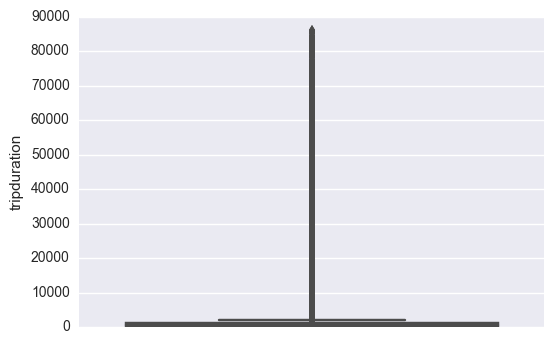

In [10]:
%%time
%matplotlib inline

    # BoxPlot Trip Duration AFTER removal of outliers
sns.boxplot(y = "tripduration", data = CitiBikeDataCompiled)
sns.despine()

    # Log Transform Column Added
CitiBikeDataCompiled["tripdurationLog"] = CitiBikeDataCompiled["tripduration"].apply(np.log)


Wall time: 1.46 s


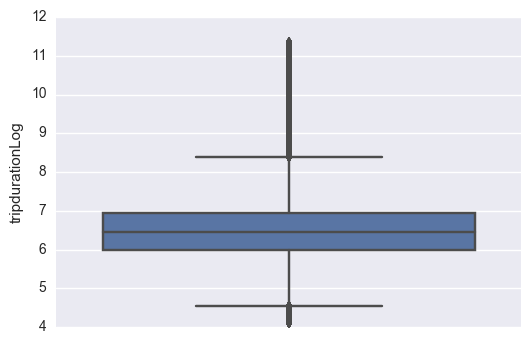

In [11]:
%%time
%matplotlib inline

    # BoxPlot TripDurationLog
sns.boxplot(y = "tripdurationLog", data = CitiBikeDataCompiled)
sns.despine()

**Age**
Similarly, we look at the distribution of Age in our dataset. Interestingly, it seems we have several outlier observations logging their birth year far enough back to cause their age to compute as 115 years old. Possible reasons for these outlier ages could be data entry errors by those who do not enjoy disclosing personal information, or possibly account sharing between a parent and a child - rendering an inaccurate data point to those actually taking the trip. Our target demographic for this study are those individuals under 65 years of age, given that they are the likely age groups to be in better physical condition for the bike share service. Given this target demographic, and the poor entries causing extreme outliers, we have chosen to limit out dataset to observations up to 65 years of age. This change removed an additional 53824 records from the dataset.

53824
Wall time: 7.04 s


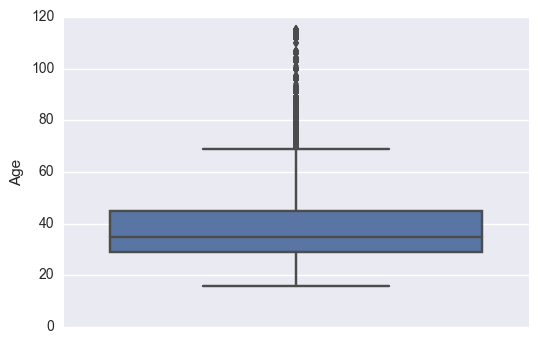

In [12]:
%%time
%matplotlib inline

    # BoxPlot Age - Outliers!
sns.boxplot(y = "Age", data = CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]!= 0])
sns.despine()
    
    # How Many Greater than 65 years old?
print(len(CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]>65]))

    # Remove > 65 years old
CitiBikeDataCompiled = CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]<=65]


Wall time: 3.56 s


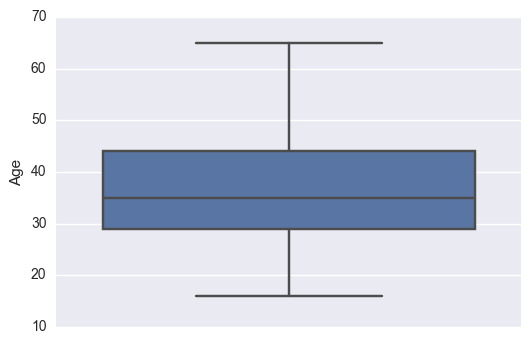

In [13]:
%%time
%matplotlib inline

    # BoxPlot Age - removed Outliers!
sns.boxplot(y = "Age", data = CitiBikeDataCompiled[CitiBikeDataCompiled["Age"]!= 0])
sns.despine()

###### Record Sampling to 500,000 Records
Given the extremely large volume of data collected, we have have decided to try to sample down to ~ 1/10th of the original dataset for a total of 500,000 records. Before taking this action, however we wanted to ensure that we keep data proportions reasonable for analysis and ensure we do not lose any important demographic in our data.

Below we compute the percentage of our Dataset that comprises of Customers vs. Subscribers. We note, that 87.6% of the data consists of Subscriber users whereas the remaining 12.4% resemble Customers. 

,usertype,count
0,Customer,680796
1,Subscriber,4827216


Wall time: 767 ms


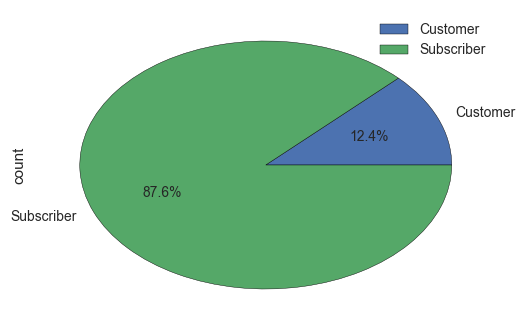

In [14]:
%%time
%matplotlib inline
UserTypeDist = pd.DataFrame({'count' : CitiBikeDataCompiled.groupby(["usertype"]).size()}).reset_index()
display(UserTypeDist)

UserTypeDist.plot.pie(y = 'count', labels = ['Customer', 'Subscriber'], autopct='%1.1f%%')

In our Sample Dataset for this analysis, we have chosen to oversample the Customer observations to force a 50/50 split between the two classifications. This will help reduce bias in the model towards Subscribers simply due to the distribution of data in the sample.

We are able to compute the sample size for each usertype and then take a random sample within each group. Below you will see that our sampled distribution matches the chosen 50/50 split between Customers and Subscriber Usertypes. 

500000


,usertype,count
0,Customer,250000
1,Subscriber,250000


Wall time: 6.8 s


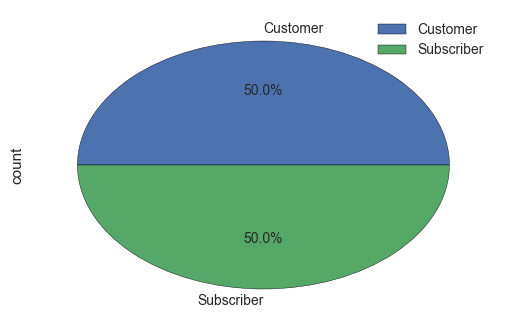

In [15]:
%%time
SampleSize = 500000

CustomerSampleSize_Seed   = int(round(SampleSize * 50.0 / 100.0,0))
SubscriberSampleSize_Seed = int(round(SampleSize * 50.0 / 100.0,0))

CitiBikeCustomerDataSampled = CitiBikeDataCompiled[CitiBikeDataCompiled["usertype"] == 'Customer'].sample(n=CustomerSampleSize_Seed, replace = False, random_state = CustomerSampleSize_Seed)
CitiBikeSubscriberDataSampled = CitiBikeDataCompiled[CitiBikeDataCompiled["usertype"] == 'Subscriber'].sample(n=SubscriberSampleSize_Seed, replace = False, random_state = SubscriberSampleSize_Seed)

CitiBikeDataSampled_5050 = pd.concat([CitiBikeCustomerDataSampled,CitiBikeSubscriberDataSampled])

print(len(CitiBikeDataSampled_5050))

UserTypeDist = pd.DataFrame({'count' : CitiBikeDataSampled_5050.groupby(["usertype"]).size()}).reset_index()
display(UserTypeDist)

UserTypeDist.plot.pie(y = 'count', labels = ['Customer', 'Subscriber'], autopct='%1.1f%%')



To prove our theories on a 50/50 classification distribution, we have also computed a stratified sample to match the original data proportions. We will use this dataset for comparisons on accuracy measures in our analysis to make sure this was the correct approach. 

500000


,usertype,count
0,Customer,62000
1,Subscriber,438000


Wall time: 9.36 s


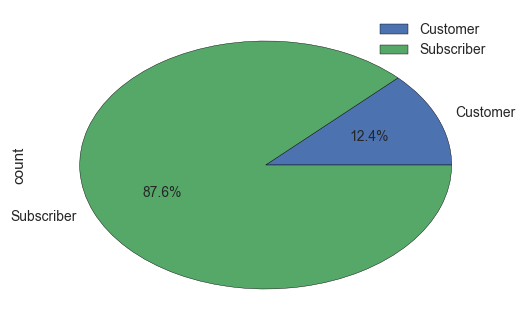

In [16]:
%%time
SampleSize = 500000

CustomerSampleSize_Seed   = int(round(SampleSize * 12.4 / 100.0,0))
SubscriberSampleSize_Seed = int(round(SampleSize * 87.6 / 100.0,0))

CitiBikeCustomerDataSampled = CitiBikeDataCompiled[CitiBikeDataCompiled["usertype"] == 'Customer'].sample(n=CustomerSampleSize_Seed, replace = False, random_state = CustomerSampleSize_Seed)
CitiBikeSubscriberDataSampled = CitiBikeDataCompiled[CitiBikeDataCompiled["usertype"] == 'Subscriber'].sample(n=SubscriberSampleSize_Seed, replace = False, random_state = SubscriberSampleSize_Seed)

CitiBikeDataSampled_orig = pd.concat([CitiBikeCustomerDataSampled,CitiBikeSubscriberDataSampled])

print(len(CitiBikeDataSampled_orig))

UserTypeDist = pd.DataFrame({'count' : CitiBikeDataSampled_orig.groupby(["usertype"]).size()}).reset_index()
display(UserTypeDist)

UserTypeDist.plot.pie(y = 'count', labels = ['Customer', 'Subscriber'], autopct='%1.1f%%')

    ## Delete Compiled full 5 million record set variable
del CitiBikeDataCompiled

### Create a Logistic Regression(LR) Model

xxxxxxxxx create model here xxxxxxxxx <br>
xxxxxxxxx prove that variables included are best for the model xxxxxxxxx

##### Prepping Data for Analysis

Now that we have the dataset sampled, we still have some legwork necessary to convert our categorical attributes into integer values. Below we walk through this process for the following Attributes:
- start_station_name
- end_station_name
- gender
- DayOfWeek
- TimeOfDay

Once these 5 attributes have been encoded using OneHotEncoding, we have added 79 attributes into our dataset for analysis in our model.

***Start Station Name***
Due to the extremely large quantity of start stations in our dataset (330 stations), we were required to reduce this dimension down to a manageable size. Through trial and error on top frequency stations, we have chosen to reduce this number down to ~ 10% its original number. By identifying the top 20 start stations for Subscribers / Customers separately, we found that there were 9 overlapping stations, producing a final list of 31 stations. While encoding our start_station_name integer columns, we limit the number of columns to these stations identified.

In [17]:
%%time
    
    #How many Start Stations are there?
print(len(CitiBikeDataSampled_5050["start_station_name"].drop_duplicates()))

    # Top 15 Start Station for Subscriber Users 
startstationsubfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Subscriber'].groupby(["start_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopSubStartStations = startstationsubfreq.head(20)

del startstationsubfreq

    # Top 15 Start Station for Customer Users 
startstationcustfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Customer'].groupby(["start_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopCustStartStations = startstationcustfreq.head(20)

del startstationcustfreq

    #Concat Subscribers and Customers
TopStartStations = pd.DataFrame(pd.concat([TopSubStartStations,TopCustStartStations])["start_station_name"].drop_duplicates()).reset_index()    
print(len(TopStartStations))
display(TopStartStations[["start_station_name"]])

del TopStartStations
del TopSubStartStations
del TopCustStartStations

    #Split Start Station Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.start_station_name,prefix='start_station_name')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit[["start_station_name_Pershing Square N", "start_station_name_E 17 St & Broadway", "start_station_name_8 Ave & W 31 St", "start_station_name_Lafayette St & E 8 St", "start_station_name_W 21 St & 6 Ave", "start_station_name_8 Ave & W 33 St", "start_station_name_W 20 St & 11 Ave", "start_station_name_Broadway & E 14 St", "start_station_name_Broadway & E 22 St", "start_station_name_W 41 St & 8 Ave", "start_station_name_Cleveland Pl & Spring St", "start_station_name_University Pl & E 14 St", "start_station_name_West St & Chambers St", "start_station_name_E 43 St & Vanderbilt Ave", "start_station_name_Broadway & W 24 St", "start_station_name_Greenwich Ave & 8 Ave", "start_station_name_W 18 St & 6 Ave", "start_station_name_Broadway & W 60 St", "start_station_name_Pershing Square S", "start_station_name_W 33 St & 7 Ave", "start_station_name_Central Park S & 6 Ave", "start_station_name_Centre St & Chambers St", "start_station_name_Grand Army Plaza & Central Park S", "start_station_name_Vesey Pl & River Terrace", "start_station_name_Broadway & W 58 St", "start_station_name_West Thames St", "start_station_name_12 Ave & W 40 St", "start_station_name_9 Ave & W 14 St", "start_station_name_W 14 St & The High Line", "start_station_name_State St", "start_station_name_Broadway & Battery Pl"]]),axis=1) # add back into the dataframe

del AttSplit

330
31


,start_station_name
0,Pershing Square N
1,E 17 St & Broadway
2,8 Ave & W 31 St
3,Lafayette St & E 8 St
4,W 21 St & 6 Ave
5,8 Ave & W 33 St
6,W 20 St & 11 Ave
7,Broadway & E 14 St
8,Broadway & E 22 St
9,W 41 St & 8 Ave


Wall time: 2.59 s


***End Station Name***
Similarly, we have an extremely large quantity of end stations in our dataset (330 stations). We were required to reduce this dimension down to a manageable size. Through trial and error on top frequency stations, we have chosen to reduce this number down to ~ 10% its original number. By identifying the top 20 end stations for Subscribers / Customers separately, we found that there were 7 overlapping stations, producing a final list of 33 stations. While encoding our end_station_name integer columns, we limit the number of columns to these stations identified.

In [18]:
%%time
    
    #How many End Stations are there?
print(len(CitiBikeDataSampled_5050["end_station_name"].drop_duplicates()))

    # Top 15 Start Station for Subscriber Users 
endstationsubfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Subscriber'].groupby(["end_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopSubendStations = endstationsubfreq.head(20)

del endstationsubfreq

    # Top 15 Start Station for Customer Users 
endstationcustfreq = pd.DataFrame({'count' : CitiBikeDataSampled_5050[CitiBikeDataSampled_5050["usertype"] == 'Customer'].groupby(["end_station_name"]).size()}).reset_index().sort_values('count',ascending = False)
TopCustendStations = endstationcustfreq.head(20)

del endstationcustfreq

    #Concat Subscribers and Customers
TopendStations = pd.DataFrame(pd.concat([TopSubendStations,TopCustendStations])["end_station_name"].drop_duplicates()).reset_index()    
print(len(TopendStations))
display(TopendStations[["end_station_name"]])

del TopendStations
del TopSubendStations
del TopCustendStations

    #Split Start Station Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.end_station_name,prefix='end_station_name')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit[["end_station_name_E 17 St & Broadway", "end_station_name_Lafayette St & E 8 St", "end_station_name_8 Ave & W 31 St", "end_station_name_W 21 St & 6 Ave", "end_station_name_Pershing Square N", "end_station_name_W 20 St & 11 Ave", "end_station_name_Broadway & E 14 St", "end_station_name_Broadway & E 22 St", "end_station_name_University Pl & E 14 St", "end_station_name_W 41 St & 8 Ave", "end_station_name_West St & Chambers St", "end_station_name_Cleveland Pl & Spring St", "end_station_name_Greenwich Ave & 8 Ave", "end_station_name_E 43 St & Vanderbilt Ave", "end_station_name_Broadway & W 24 St", "end_station_name_W 18 St & 6 Ave", "end_station_name_MacDougal St & Prince St", "end_station_name_Carmine St & 6 Ave", "end_station_name_8 Ave & W 33 St", "end_station_name_2 Ave & E 31 St", "end_station_name_Central Park S & 6 Ave", "end_station_name_Centre St & Chambers St", "end_station_name_Grand Army Plaza & Central Park S", "end_station_name_Broadway & W 60 St", "end_station_name_Broadway & W 58 St", "end_station_name_12 Ave & W 40 St", "end_station_name_Vesey Pl & River Terrace", "end_station_name_W 14 St & The High Line", "end_station_name_9 Ave & W 14 St", "end_station_name_West Thames St", "end_station_name_State St", "end_station_name_Old Fulton St", "end_station_name_South End Ave & Liberty St"]]),axis=1) # add back into the dataframe

del AttSplit

330
33


,end_station_name
0,E 17 St & Broadway
1,Lafayette St & E 8 St
2,8 Ave & W 31 St
3,W 21 St & 6 Ave
4,Pershing Square N
5,W 20 St & 11 Ave
6,Broadway & E 14 St
7,Broadway & E 22 St
8,University Pl & E 14 St
9,W 41 St & 8 Ave


Wall time: 2.54 s


**Gender, DayOfWeek, and TimeOfDay**
The rest of our encoding attributes {Gender, DayOfWeek, and TimeOfDay} have the following value permutations. These permutations will be encoded as individual binary columns as well.

- Gender:    {0 = unknown, 1 = male, 2 = female}
- DayOfWeek: {Sunday, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday}
- TimeOfDay: {Morning, Midday, Afternoon, Evening, Night}

With these encodings complete, our final dataset to cross-validate on test/train datasets is complete.

In [19]:
%%time

    #Split gender Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.gender,prefix='gender')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

    #Split DayOfWeek Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.DayOfWeek,prefix='DayOfWeek')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

    #Split TimeOfDay Values for 50/50 dataset
AttSplit = pd.get_dummies(CitiBikeDataSampled_5050.TimeOfDay,prefix='TimeOfDay')
CitiBikeDataSampled_5050 = pd.concat((CitiBikeDataSampled_5050,AttSplit),axis=1) # add back into the dataframe

del AttSplit

display(CitiBikeDataSampled_5050.head())


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth year,gender,LinearDistance,DayOfWeek,TimeOfDay,HolidayFlag,PRCP,SNOW,TAVE,TMAX,TMIN,Age,tripdurationLog,start_station_name_Pershing Square N,start_station_name_E 17 St & Broadway,start_station_name_8 Ave & W 31 St,start_station_name_Lafayette St & E 8 St,start_station_name_W 21 St & 6 Ave,start_station_name_8 Ave & W 33 St,start_station_name_W 20 St & 11 Ave,start_station_name_Broadway & E 14 St,start_station_name_Broadway & E 22 St,start_station_name_W 41 St & 8 Ave,start_station_name_Cleveland Pl & Spring St,start_station_name_University Pl & E 14 St,start_station_name_West St & Chambers St,start_station_name_E 43 St & Vanderbilt Ave,start_station_name_Broadway & W 24 St,start_station_name_Greenwich Ave & 8 Ave,start_station_name_W 18 St & 6 Ave,start_station_name_Broadway & W 60 St,start_station_name_Pershing Square S,start_station_name_W 33 St & 7 Ave,start_station_name_Central Park S & 6 Ave,start_station_name_Centre St & Chambers St,start_station_name_Grand Army Plaza & Central Park S,start_station_name_Vesey Pl & River Terrace,start_station_name_Broadway & W 58 St,start_station_name_West Thames St,start_station_name_12 Ave & W 40 St,start_station_name_9 Ave & W 14 St,start_station_name_W 14 St & The High Line,start_station_name_State St,start_station_name_Broadway & Battery Pl,end_station_name_E 17 St & Broadway,end_station_name_Lafayette St & E 8 St,end_station_name_8 Ave & W 31 St,end_station_name_W 21 St & 6 Ave,end_station_name_Pershing Square N,end_station_name_W 20 St & 11 Ave,end_station_name_Broadway & E 14 St,end_station_name_Broadway & E 22 St,end_station_name_University Pl & E 14 St,end_station_name_W 41 St & 8 Ave,end_station_name_West St & Chambers St,end_station_name_Cleveland Pl & Spring St,end_station_name_Greenwich Ave & 8 Ave,end_station_name_E 43 St & Vanderbilt Ave,end_station_name_Broadway & W 24 St,end_station_name_W 18 St & 6 Ave,end_station_name_MacDougal St & Prince St,end_station_name_Carmine St & 6 Ave,end_station_name_8 Ave & W 33 St,end_station_name_2 Ave & E 31 St,end_station_name_Central Park S & 6 Ave,end_station_name_Centre St & Chambers St,end_station_name_Grand Army Plaza & Central Park S,end_station_name_Broadway & W 60 St,end_station_name_Broadway & W 58 St,end_station_name_12 Ave & W 40 St,end_station_name_Vesey Pl & River Terrace,end_station_name_W 14 St & The High Line,end_station_name_9 Ave & W 14 St,end_station_name_West Thames St,end_station_name_State St,end_station_name_Old Fulton St,end_station_name_South End Ave & Liberty St,gender_0,gender_1,gender_2,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Midday,TimeOfDay_Morning,TimeOfDay_Night
178325,2023,2013-07-07 14:25:39,2013-07-07 14:59:22,245,Myrtle Ave & St Edwards St,40.693270,-73.977039,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,17767,Customer,0,0,1.760372,Sunday,Afternoon,0,0.00,0.0,85,92,78,0,7.612337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0
112533,383,2013-10-09 20:27:55,2013-10-09 20:34:18,334,W 20 St & 7 Ave,40.742388,-73.997262,509,9 Ave & W 22 St,40.745497,-74.001971,18523,Customer,0,0,0.327278,Wednesday,Evening,0,0.00,0.0,58,62,53,0,5.948035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
199683,634,2013-09-01 17:40:41,2013-09-01 17:51:15,363,West Thames St,40.708347,-74.017134,3002,South End Ave & Liberty St,40.711512,-74.015756,20173,Customer,0,0,0.230075,Sunday,Evening,0,0.00,0.0,80,84,75,0,6.452049,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Wall time: 3.89 s


##### Build Test & Train Datasets
*(Note: Below code adapted from MSDS 7331 Data Mining Git Repository Notebook 4)*

With our final encoded dataset complete, we begin splitting the data into Test vs Train datasets. The test dataset size for this analysis is 20% of the original data (e.g. 100,000 records). We have utilized a random_state seed equal to the length of the original sampled dataset to ensure reproducible results.



In [20]:
%%time

## Create function to create sample test/train datasets with inputs of:
    ## original dataset, 
    ## explanatory dataset (removing appropriate columns not included in model), 
    ## random seed value
def create_sample(Data, dropCols, seed):
    if 'usertype' in CitiBikeDataSampled_5050:
        y = CitiBikeDataSampled_5050['usertype'].values # get the labels we want
        #del CitiBikeDataSampled_5050['usertype'] # get rid of the class label
        X = CitiBikeDataSampled_5050.drop(dropCols, axis = 1).values
        y = np.where(y == 'Subscriber', 1, 0)

    # to use the cross validation object in scikit learn, we need to grab an instance
    #    of the object and set it up. This object will be able to split our data into 
    #    training and testing splits
    num_cv_iterations = 3
    num_instances = len(y)
    cv_object = ShuffleSplit(n=num_instances,
                             n_iter=num_cv_iterations,
                             test_size  = 0.2,
                             random_state = seed)

    return cv_object, X, y

## Create function to Execute fit and prediction, cross validating 3 test/train combos
    # print output for accuracy metrics
    # return key attributes for last iteration for future use
def test_LRModel(cv_object, X, y):

    lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

    iter_num=0

    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        lr_clf.fit(X[train_indices],y[train_indices])  # train object
        y_hat = lr_clf.predict(X[test_indices]) # get test set preditions

        # print the accuracy and confusion matrix 
        print("====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
        print("confusion matrix\n", pd.crosstab(y[test_indices], y_hat, rownames = ['True'], colnames = ['Predicted'], margins = True))
        print("log_loss = ", log_loss(y[test_indices], y_hat))
        print("roc_auc_score = ", roc_auc_score(y[test_indices], y_hat))
        print("F-score = ", mt.f1_score(y[test_indices], y_hat))
    
    del cv_object
    return lr_clf, X[train_indices],y[train_indices], X[test_indices], y_hat





ShuffleSplit(500000, n_iter=3, test_size=0.2, random_state=None)
Wall time: 1.99 s


In [21]:
%%time

# define random seed value to re-use
seed = len(CitiBikeDataSampled_5050)

# build sample test/train with all variables minus time series, redundant station ids, 
    # trip duration, and original columns for encoded binary columns
cv_object_All, X_All, y_All = create_sample(CitiBikeDataSampled_5050, 
                                            ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration'], 
                                            seed)
print(cv_object_All)

# Execute fit and prediction, cross validating 3 test/train combos
    # print output for accuracy metrics
    # return key attributes for last iteration for future use
lr_clf_All, X_Train_All, y_Train_All, x_Test_All, y_hat_All = test_LRModel(cv_object_All, X_All, y_All)

del X_All, y_All

====Iteration 0  ====
accuracy 0.99991
confusion matrix
 [[50224     9]
 [    0 49767]]
Predicted      0      1     All
True                           
0          50224      9   50233
1              0  49767   49767
All        50224  49776  100000
log_loss =  0.00310856183931
roc_auc_score =  0.999910417455
F-score =  0.999909586812
====Iteration 1  ====
accuracy 0.99991
confusion matrix
 [[50176     9]
 [    0 49815]]
Predicted      0      1     All
True                           
0          50176      9   50185
1              0  49815   49815
All        50176  49824  100000
log_loss =  0.00310856183931
roc_auc_score =  0.999910331772
F-score =  0.999909673923
====Iteration 2  ====
accuracy 0.9999
confusion matrix
 [[49957    10]
 [    0 50033]]
Predicted      0      1     All
True                           
0          49957     10   49967
1              0  50033   50033
All        49957  50043  100000
log_loss =  0.00345395759924
roc_auc_score =  0.999899933956
F-score =  0.999900075

**Including age, year, and gender falsely improves the accuracy of our model**

In [22]:
%%time

# build sample test/train with all variables minus time series, redundant station ids, 
    # trip duration, original columns for encoded binary columns,
    # AND Non-Customer provided data {Age, Birth Year, Gender}
cv_object_RemABYG, X_RemABYG, y_RemABYG = create_sample(CitiBikeDataSampled_5050, 
                                                        ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year'], 
                                                        seed)
print(cv_object_RemABYG)

# Execute fit and prediction, cross validating 3 test/train combos
    # print output for accuracy metrics
    # return key attributes for last iteration for future use
lr_clf_RemABYG, X_Train_RemABYG, y_Train_RemABYG, x_Test_RemABYG, y_hat_RemABYG = test_LRModel(cv_object_RemABYG, X_RemABYG, y_RemABYG)

del X_RemABYG, y_RemABYG

====Iteration 0  ====
accuracy 0.74775
Predicted      0      1     All
True                           
0          37395  12616   50011
1          12609  37380   49989
All        50004  49996  100000
log_loss =  8.71250722283
roc_auc_score =  0.747750003191
F-score =  0.747712156824
====Iteration 1  ====
accuracy 0.7464
Predicted      0      1     All
True                           
0          37431  12539   49970
1          12821  37209   50030
All        50252  49748  100000
log_loss =  8.75913395527
roc_auc_score =  0.746401600705
F-score =  0.745835755377
====Iteration 2  ====
accuracy 0.7456
Predicted      0      1     All
True                           
0          37286  12707   49993
1          12733  37274   50007
All        50019  49981  100000
log_loss =  8.78676631971
roc_auc_score =  0.745600031414
F-score =  0.745569468336
Wall time: 1min 38s


**Business focus needs to be on customers falsely identified as subscribers.**

Removing LinearDistance, bikeID, 

In [23]:
from sklearn.feature_selection import f_regression

In [24]:
%%time

# build sample test/train with all variables minus time series, redundant station ids, 
    # trip duration, original columns for encoded binary columns,
    # AND Non-Customer provided data {Age, Birth Year, Gender}
    # AND LinearDistance
    # AND BikeID
cv_object_RemABYG_LDBID, X_RemABYG_LDBID, y_RemABYG_LDBID = create_sample(CitiBikeDataSampled_5050, 
                                                                          ['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year','LinearDistance', 'bikeid'], 
                                                                          seed)
print(cv_object_RemABYG_LDBID)

# Execute fit and prediction, cross validating 3 test/train combos
    # print output for accuracy metrics
    # return key attributes for last iteration for future use
lr_clf_RemABYG_LDBID, X_Train_RemABYG_LDBID, y_Train_RemABYG_LDBID, x_Test_RemABYG_LDBID, y_hat_RemABYG_LDBID = test_LRModel(cv_object_RemABYG_LDBID, X_RemABYG_LDBID, y_RemABYG_LDBID)

del X_RemABYG_LDBID, y_RemABYG_LDBID

====Iteration 0  ====
accuracy 0.73781
Predicted      0      1     All
True                           
0          37224  12873   50097
1          13346  36557   49903
All        50570  49430  100000
log_loss =  9.05582471516
roc_auc_score =  0.737799836983
F-score =  0.73604944983
====Iteration 1  ====
accuracy 0.73774
Predicted      0      1     All
True                           
0          37067  12803   49870
1          13423  36707   50130
All        50490  49510  100000
log_loss =  9.05824186979
roc_auc_score =  0.737754347219
F-score =  0.73679245283
====Iteration 2  ====
accuracy 0.73982
Predicted      0      1     All
True                           
0          37363  12713   50076
1          13305  36619   49924
All        50668  49332  100000
log_loss =  8.98640049525
roc_auc_score =  0.739810400458
F-score =  0.737869750947
Wall time: 1min 7s


### Create a Support Vector Machine(SVM) Model

xxxxxxxxx create model here xxxxxxxxx <br>
xxxxxxxxx prove that variables included are best for the model xxxxxxxxx

*(This code as it is presently only addresses the data set combination of attributes used for the last logistic regression model)*

In [ ]:
#%%time
#
#scl_obj = StandardScaler()
#scl_obj.fit(X[train_indices])
#
#X_train_scaled = scl_obj.transform(X[train_indices]) # apply to training
#X_test_scaled = scl_obj.transform(X[test_indices])
#
## Train the SVM model
#svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
#svm_clf.fit(X_train_scaled, y[train_indices])  # train object
#
#y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
#
#acc = mt.accuracy_score(y[test_indices],y_hat)
#conf = mt.confusion_matrix(y[test_indices],y_hat)
#print('accuracy:', acc )
#print(conf)

In [25]:
%%time

regularize_const = 0.1
svm_sgd = SGDClassifier(alpha=regularize_const, l1_ratio=0.0, n_jobs=-1)

scl = StandardScaler()

svm_sgd.fit(scl.fit_transform(X[train_indices]), y[train_indices])
yhat = svm_sgd.predict(scl.transform(X[test_indices]))

conf = mt.confusion_matrix(y[test_indices],yhat)
acc = mt.accuracy_score(y[test_indices],yhat)

print('SVM:', acc)
print(pd.crosstab(y[test_indices], yhat, rownames = ['True'], colnames = ['Predicted'], margins = True))

C:\Users\Owner\Anaconda2\envs\Py3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


SVM: 0.73869
[[37765 12311]
 [13820 36104]]
Predicted      0      1     All
True                           
0          37765  12311   50076
1          13820  36104   49924
All        51585  48415  100000
Wall time: 15.8 s


In [28]:
# make a dataframe of the training data
df_tested_on = CitiBikeDataSampled_5050.drop(['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year','LinearDistance', 'bikeid'], axis = 1) # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_sgd.support_,:]

df_support['usertype'] = y[svm_sgd.support_] # add back in the 'Survived' Column to the pandas dataframe
#df_imputed['Survived'] = y # also add it back in for the original data
df_support.info()

AttributeError: 'SGDClassifier' object has no attribute 'support_'

### Pros and Cons of LR vs. SVM

xxxxxxxxx Adv. of each model xxxxxxxxx <br>
xxxxxxxxx Disadv. of each model xxxxxxxxx <br>
xxxxxxxxx superior model in terms of accuracy, training time/efficiency? xxxxxxxxx

### LR Feature Weightings Explained

xxxxxxxxx Discuss/interpret coefficients of each feature. xxxxxxxxx

In [ ]:
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = CitiBikeDataSampled_5050.drop(['starttime','stoptime','start_station_id','start_station_name','end_station_id','end_station_name','usertype','gender','DayOfWeek','TimeOfDay','tripduration','Age','gender_0','gender_1','gender_2','birth year','LinearDistance', 'bikeid'], axis = 1).columns # use everything else to predict!
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

In [ ]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X[train_indices]) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X[train_indices]) # apply to training
X_test_scaled = scl_obj.transform(X[test_indices]) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y[train_indices])  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y[test_indices],y_hat)
conf = mt.confusion_matrix(y[test_indices],y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,variable_names) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

weights = pd.Series(lr_clf.coef_[0],index=variable_names)
weights.plot(kind='bar')
plt.show()

### Support Vectors Explained

xxxxxxxxx Do the support vectors provide any insight into the data? xxxxxxxxx

### Exceptional Work

xxxxxxxxx Explain Exc. Work Details / Challenges encountered here. xxxxxxxxx